# Advanced Object Detection

## Initialization

In [1]:
# Install required libraries
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.7 MB/s eta

In [2]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
from torch_snippets import *
from PIL import Image
from sklearn.model_selection import train_test_split

from google.colab import files
!nvidia-smi # check if GPU is available
%matplotlib inline

Fri Mar  1 18:32:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

## Faster R-CNN custom object detector

<table>
    <tbody>
        <tr>
            <td>
                <img src="faster_r-cnn.png" alt="Faster R-CNN" height="300">
            </td>
        </tr>
    </tbody>
</table>

In [4]:
# Upload Kaggle Token
files.upload()

# Copy Kaggle Token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
# Download and unzip Bus Trucks dataset from Kaggle
!kaggle datasets download -d sixhky/open-images-bus-trucks -p data

# Unzip the dataset
!cd data && unzip -qq open-images-bus-trucks.zip && mv images open-images-bus-trucks

100% 365M/367M [00:05<00:00, 96.9MB/s]
100% 367M/367M [00:05<00:00, 64.7MB/s]


In [6]:
# Get the list of images
root_dir = '/content/data'
images_dir = f'{root_dir}/open-images-bus-trucks/images'
dataset_df = pd.read_csv(f'{root_dir}/df.csv')
print(dataset_df.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [7]:
# Create dictionaries with labels and targets
label2target = {label: target + 1 for target, label in enumerate(dataset_df['LabelName'].unique())}
label2target['Background'] = 0
target2label = {target: label for label, target in label2target.items()}
background_class = label2target['Background']
num_classes = len(label2target)

# Print the dictionaries
print("Label to Target:", label2target, "\n")
print("Target to Label:", target2label , "\n")
print("Background Class Index:", background_class, "\n")
print("Number of Classes:", num_classes)

Label to Target:
{'Bus': 1, 'Truck': 2, 'Background': 0}

Target to Label:
{1: 'Bus', 2: 'Truck', 0: 'Background'}

Background Class Index: 0

Number of Classes: 3

In [8]:
# Create a function to preprocess images
def preprocess_image(image):
    return torch.tensor(image).permute(2,0,1).to(device).float()

In [9]:
# Create Dataset class to fetch images and labels
class OpenImages(Dataset):
    def __init__(self, df, image_dir=images_dir):
        self.w, self.h = (224, 224)
        self.image_dir = image_dir
        self.files = Glob(f'{self.image_dir}/*')
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self): return len(self.unique_images)

    def __getitem__(self, idx):
        # Get the image id and path and read the image
        image_id = self.unique_images[idx]
        image_path = find(image_id, self.files)
        image = Image.open(image_path).convert("RGB")
        image = np.array(image.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        image = preprocess_image(image)

        # Get the classes
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()

        # Get the bounding boxes and convert to absolute coordinates
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()

        # FRCNN implementation in torch expects ground truths as a dictionary of tensors
        target = {"boxes": torch.Tensor(boxes).float()}
        target["labels"] = torch.Tensor([label2target[label] for label in labels]).long()

        return image, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [10]:
# Get the unique images and split them into train and validation sets
unique_images = dataset_df['ImageID'].unique()
train_unique, val_unique = train_test_split(unique_images, test_size=0.1, random_state=44)
print("Number of Train Images:", len(train_unique))
print("Number of Validation Images:", len(val_unique))

# Create the train and validation datasets
train_ds = OpenImages(dataset_df[dataset_df['ImageID'].isin(train_unique)])
val_ds = OpenImages(dataset_df[dataset_df['ImageID'].isin(val_unique)])

# Create a function to retrieve the dataloaders
def load_data(batch_size = 4):
    train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)
    return train_dl, val_dl

Number of Train Images: 13702

Number of Validation Images: 1523

In [11]:
# Create a function to load the model
def load_model():
    # Load a pre-trained Faster R-CNN model with a ResNet50 backbone and a Feature Pyramid Network (FPN)
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Retrieve the number of input features for the classifier from the model's Region of Interest (RoI) heads
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the model's box predictor with a FastRCNNPredictor class that has a custom number of classes and input features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Print summary of the model
model = load_model()
print(model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 149MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): C

In [12]:
# Create a function to train the model on a batch of data
def train_batch(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    images, targets = data
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    losses = model(images, targets)
    loss = sum(losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(model, data):
    model.eval()
    images, targets = data
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    losses = model(images, targets)
    loss = sum(losses.values())
    return loss, losses

EPOCH: 1.000  train_loss: 0.186  val_classifier_loss: 0.071  val_loss: 0.170  train_rpn_box_reg_loss: 0.009  val_objectness_loss: 0.013  val_rpn_box_reg_loss: 0.007  train_box_reg_loss: 0.083  train_objectness_loss: 0.018  train_classifier_loss: 0.077  val_box_reg_loss: 0.079  (2966.41s - 11865.63s remaining)
EPOCH: 2.000  train_loss: 0.158  val_classifier_loss: 0.063  val_loss: 0.150  train_rpn_box_reg_loss: 0.007  val_objectness_loss: 0.008  val_rpn_box_reg_loss: 0.006  train_box_reg_loss: 0.075  train_objectness_loss: 0.011  train_classifier_loss: 0.066  val_box_reg_loss: 0.073  (5933.65s - 8900.48s remaining)
EPOCH: 3.000  train_loss: 0.150  val_classifier_loss: 0.060  val_loss: 0.144  train_rpn_box_reg_loss: 0.007  val_objectness_loss: 0.008  val_rpn_box_reg_loss: 0.006  train_box_reg_loss: 0.072  train_objectness_loss: 0.009  train_classifier_loss: 0.062  val_box_reg_loss: 0.071  (8907.83s - 5938.56s remaining)
EPOCH: 4.000  train_loss: 0.145  val_classifier_loss: 0.060  val_loss

100%|██████████| 106/106 [00:00<00:00, 116.11it/s]


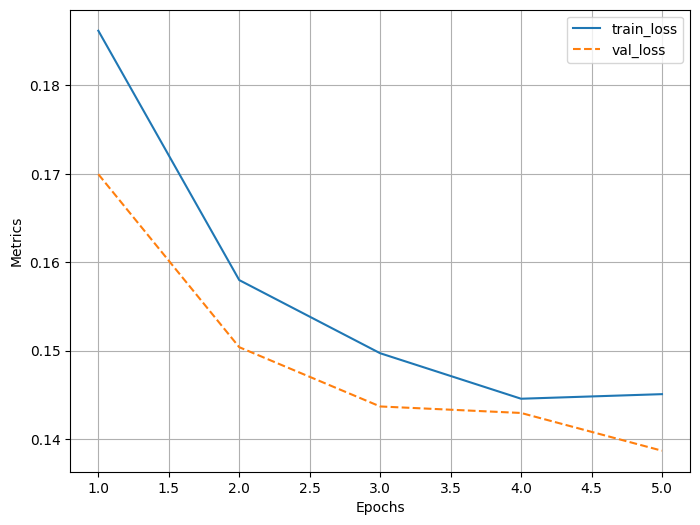

In [13]:
# Train the model
model = load_model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
train_dl, val_dl = load_data()
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, losses = train_batch(model, data, optimizer)
        loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg = [
            losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']
        ]
        log.record(
            epoch+(i+1)/n,
            train_loss=loss.item(),
            train_classifier_loss=loss_classifier,
            train_box_reg_loss=loss_box_reg,
            train_objectness_loss=loss_objectness,
            train_rpn_box_reg_loss=loss_rpn_box_reg,
            end='\r')
    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, losses = train_batch(model, data, optimizer)
        loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg = [
            losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']
        ]
        log.record(
            epoch+(i+1)/n,
            val_loss=loss.item(),
            val_classifier_loss=loss_classifier,
            val_box_reg_loss=loss_box_reg,
            val_objectness_loss=loss_objectness,
            val_rpn_box_reg_loss=loss_rpn_box_reg,
            end='\r')
    if (epoch+1) % (n_epochs//5) == 0: log.report_avgs(epoch+1)
log.plot_epochs(['train_loss', 'val_loss'])

In [14]:
# Create a function to decode the model's output
def decode_output(output):
    # Convert the tensors to numpy arrays and convert the labels to their corresponding names
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]

    # If only one object is detected, convert the tensors to lists
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

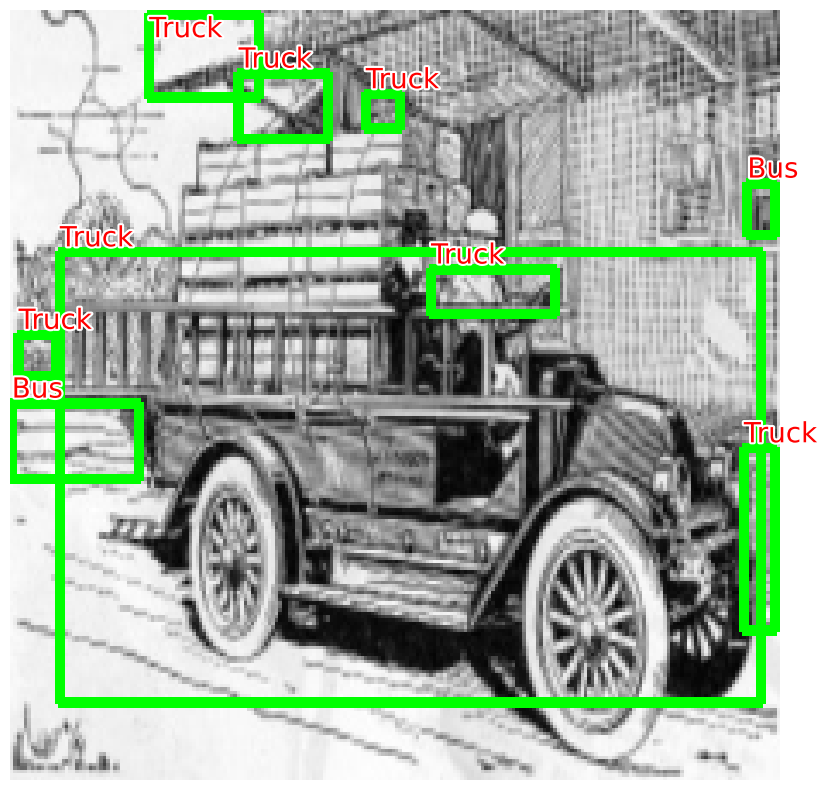

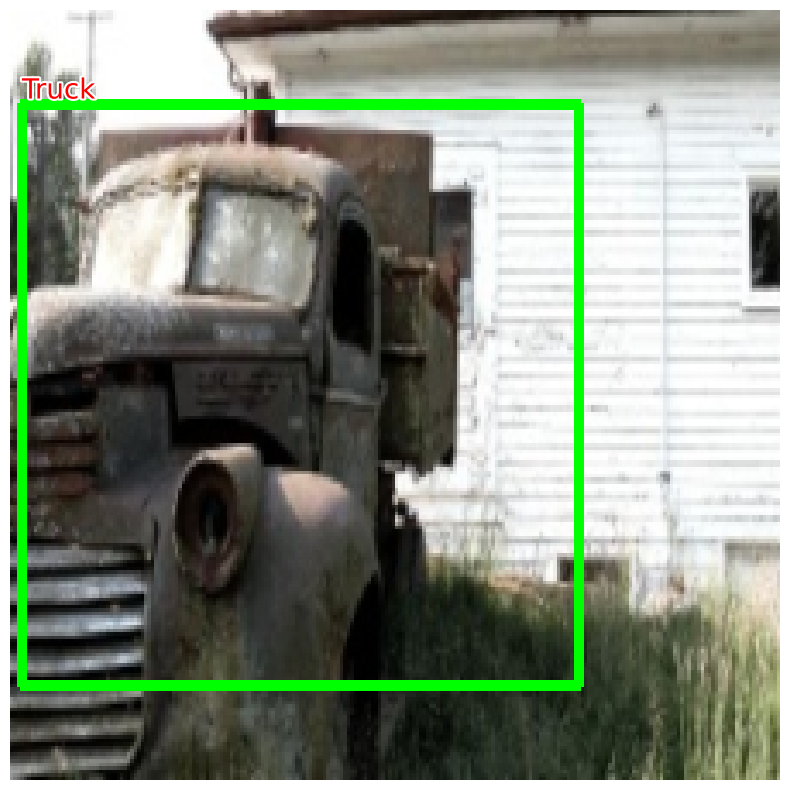

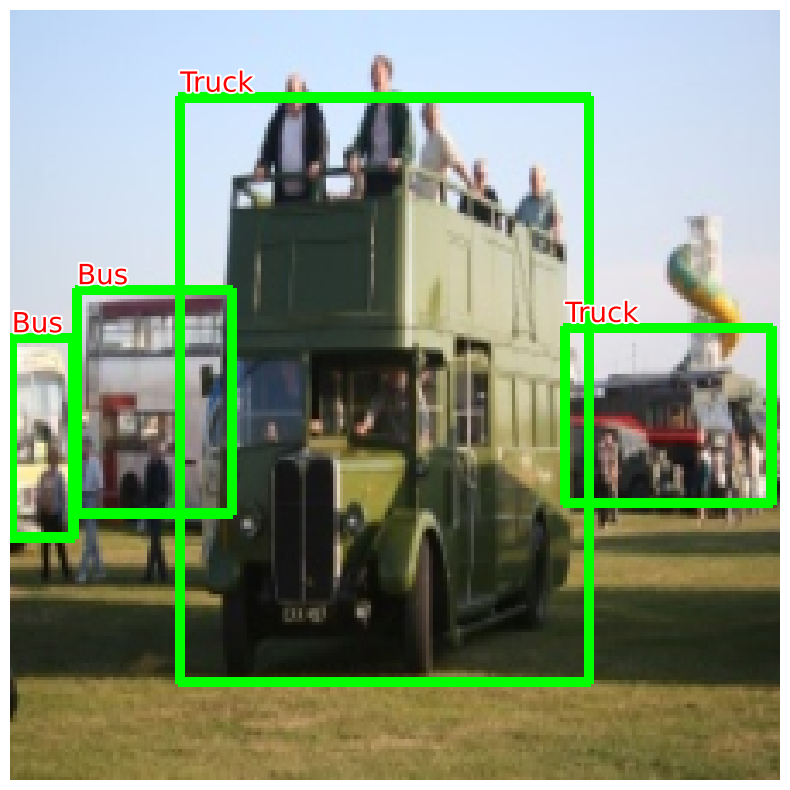

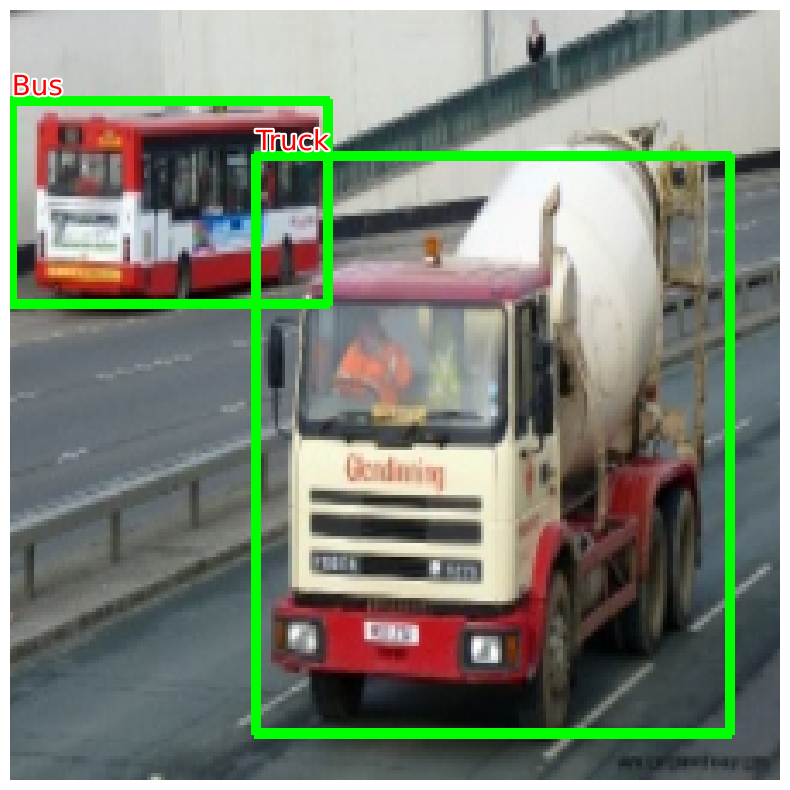

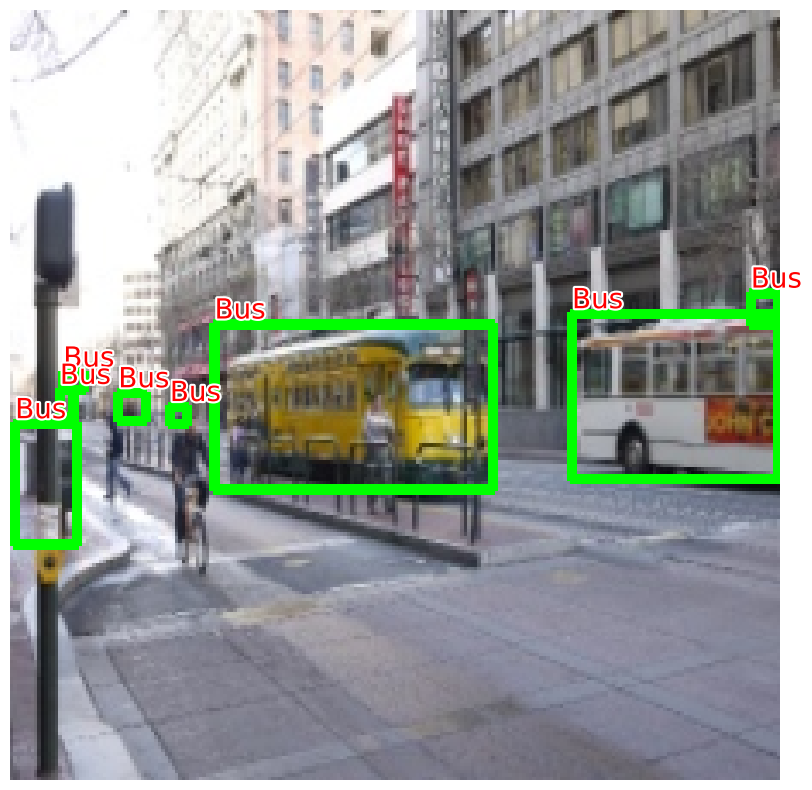

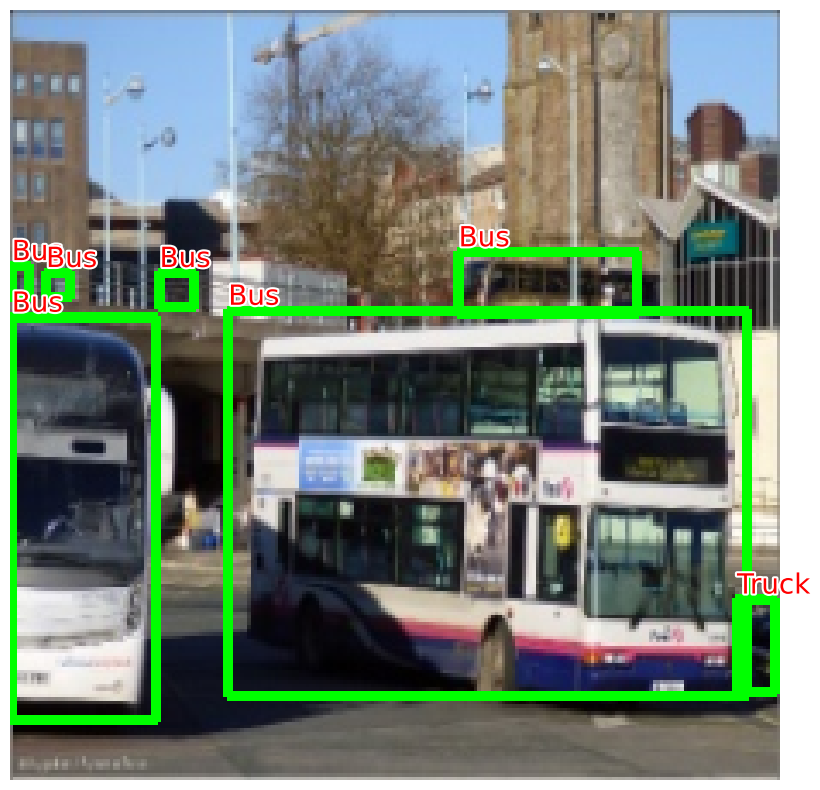

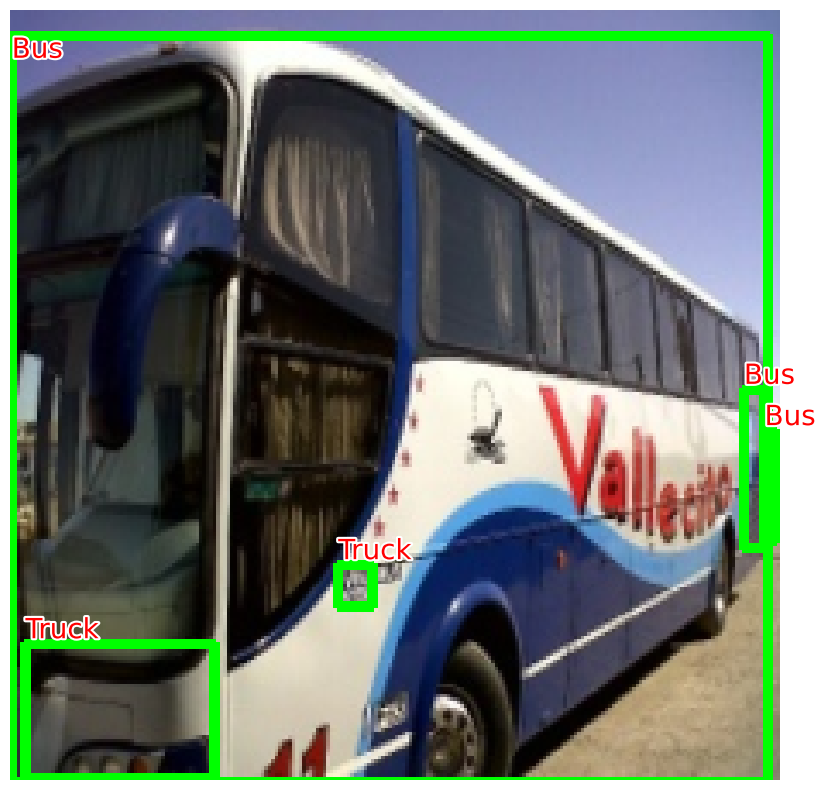

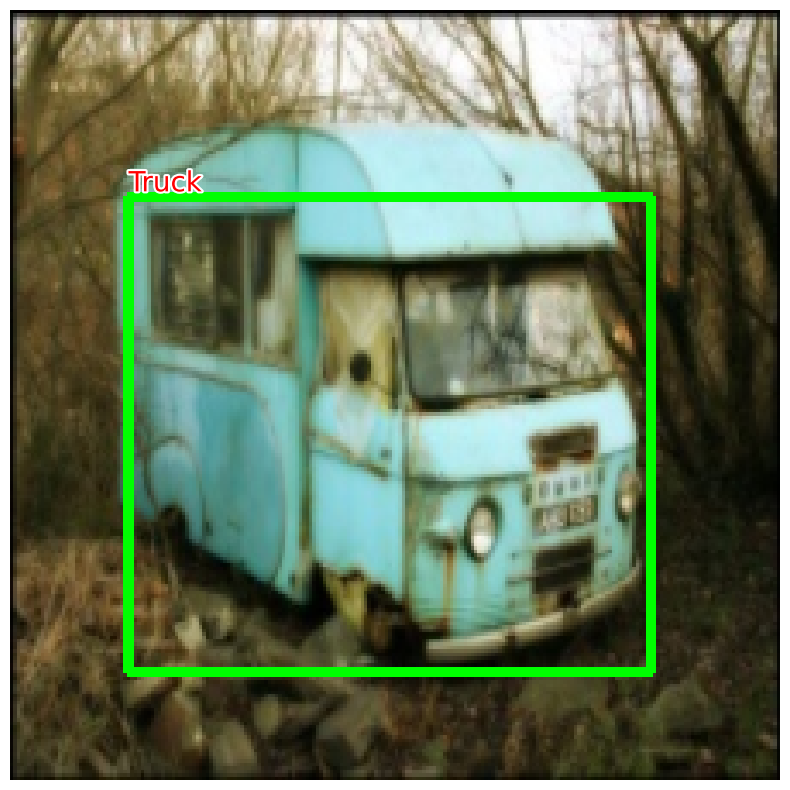

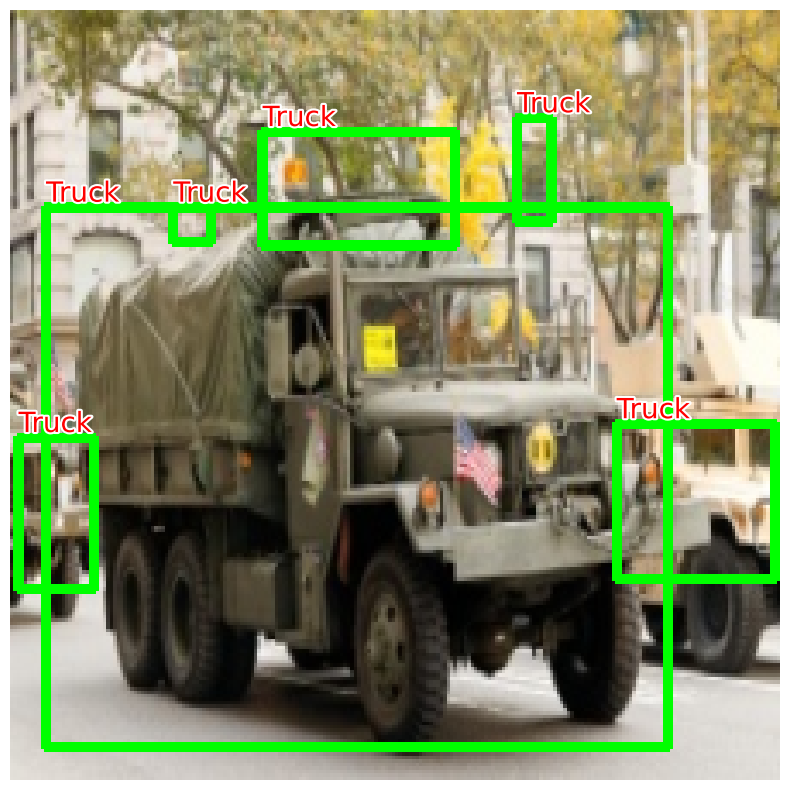

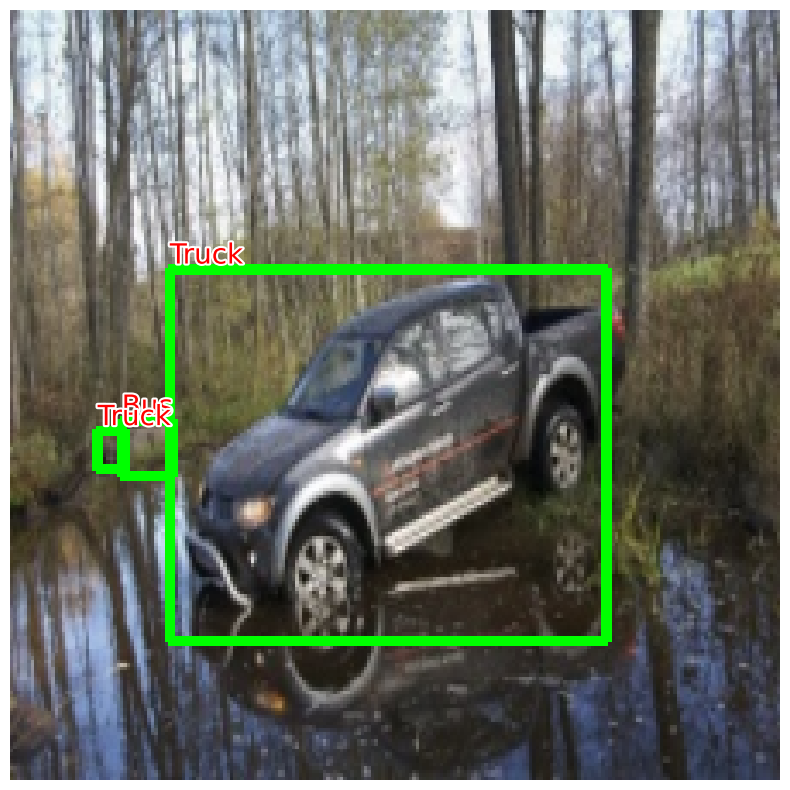

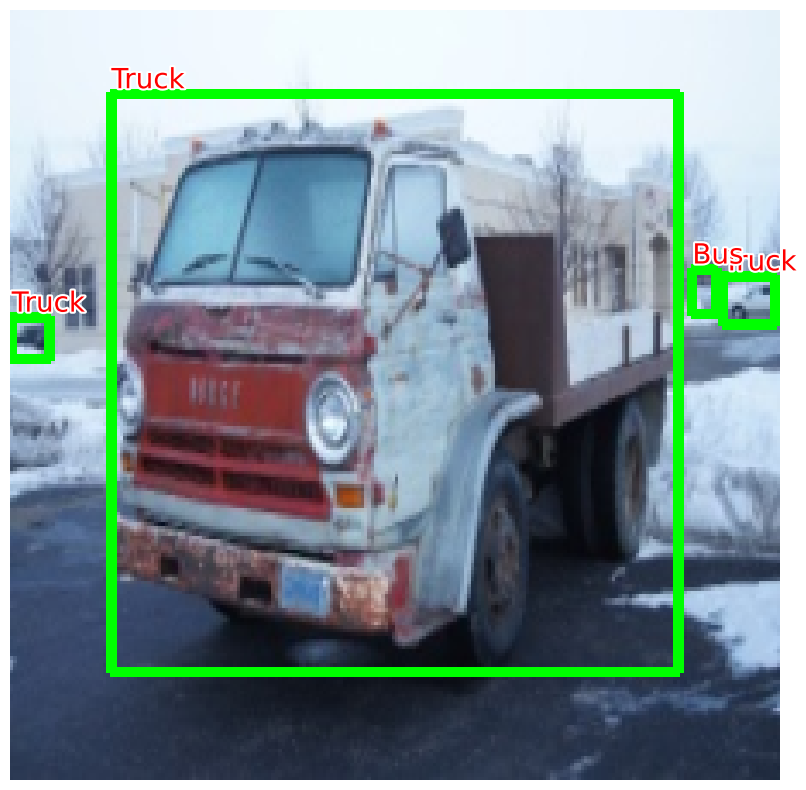

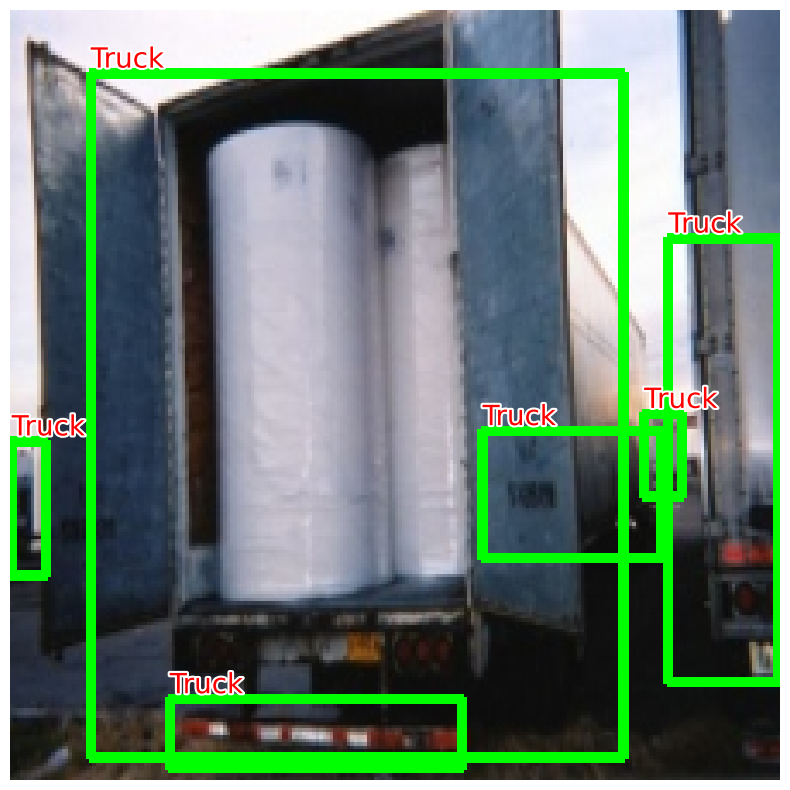

In [18]:
# Make predictions on a batch of images
model.eval()
for idx, (images, targets) in enumerate(val_dl):
    # Only show 3 batches
    if idx == 3: break

    # Make predictions on the images
    images = list(images)
    outputs = model(images)

    # Decode the model's output and display the images
    for jdx, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
        show(images[jdx].cpu().permute(1,2,0), bbs=bbs, texts=labels, text_sz=20, sz=10)